## Grad-CAM
**Data**: MixedWM38 single defect only

**Data preprocessing**: Resize to 224x224, binarize, and apply n=2 morphological thinning

**Model**: Implementation of classification model from the Yu, et al [paper](https://drive.google.com/file/d/1nYl4w41CAcj8XwTEdVwcD5lVheUFIHVy/view?usp=sharing) used to classify all defects, including nones

In [1]:
# !pip install pickle5

In [2]:
# import libraries
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import datasets, layers, models, losses, optimizers, regularizers, callbacks, Input, Model, Sequential

import os
import time
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix

import cv2
from scipy.ndimage import median_filter
from skimage.transform import resize as sk_resize
from skimage.util import img_as_ubyte
from skimage.morphology import skeletonize, thin

import helpers as helper
from keras_model_s3_wrapper import *

import boto3
import pickle5 as pickle
s3 = boto3.resource('s3')
bucket_name = 'wafer-capstone'
my_bucket = s3.Bucket(bucket_name)

In [3]:
tf.__version__

'2.3.4'

In [4]:
tf.config.list_physical_devices(device_type=None)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'),
 PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Load the data

In [5]:
# load data directly from S3 (using boto3 resource)
start = time.time()

data_key = 'processed_data/customer/MixedWM38-single.pkl'
data = pickle.loads(my_bucket.Object(data_key).get()['Body'].read())

print("Wall time: {:.2f} seconds".format(time.time() - start))
print(f"Dataset length: {len(data)}")
data.head()

Wall time: 0.36 seconds
Dataset length: 8015


,ID,waferMap,labels,label_total,failureType,detectLabels,classifyLabels
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2


### Data preprocessing

In [6]:
# resize to 224x224 --> binarize --> apply n=2 morphological thinning
start = time.time()

def resize(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    return new_y
    
data['waferMap224'] = data.waferMap.apply(lambda x: resize(x))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.waferMap224[0].shape}')
print(f'Map unique values:{np.unique(data.waferMap224[0])}')

Wall time: 16.94 seconds
Sanity checks:
Map shape: (224, 224)
Map unique values:[0 1 2]


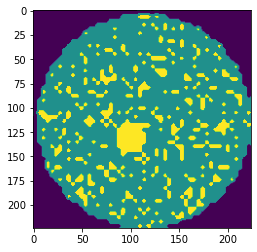

In [7]:
plt.imshow(data.waferMap224[0])

In [8]:
# resize to 224x224 --> binarize --> apply n=2 morphological thinning
start = time.time()

def preprocess(x):
    y = sk_resize(x, [224,224])
    new_y = img_as_ubyte(y)
    ret, thresh_img = cv2.threshold(new_y, 1, 1, cv2.THRESH_BINARY)
    thin_img = thin(thresh_img, 2)
    return thin_img
    
data['thinMap2'] = data.waferMap.apply(lambda x: preprocess(x))
data['thinMap2'] = data.thinMap2.apply(lambda x: x.astype(np.uint8))

print("Wall time: {:.2f} seconds".format(time.time() - start))
print("Sanity checks:")
print(f'Map shape: {data.thinMap2[0].shape}')
print(f'Map unique values:{np.unique(data.thinMap2[0])}')

Wall time: 49.43 seconds
Sanity checks:
Map shape: (224, 224)
Map unique values:[0 1]


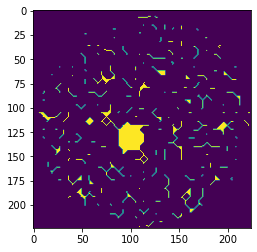

In [9]:
plt.imshow(data.thinMap2[0])

### Classify Model

In [10]:
# rebuild model

inputs = Input(shape=(224, 224, 1))
x = layers.Conv2D(32, 3, padding='same', activation='relu')(inputs)
x = layers.Conv2D(32, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.Conv2D(128, 3, padding='same', activation='relu')(x)
x = layers.MaxPooling2D(3)(x)

x = layers.Flatten()(x)
x = layers.Dense(4096, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001))(x)
x = layers.Dense(1024, activation='sigmoid', kernel_regularizer=regularizers.l2(0.000001))(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(9, activation='softmax')(x)

classify = Model(inputs=inputs, outputs=outputs)

classify.load_weights('wafermap_final_model.h5')

classify.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 1)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 32)      9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 74, 74, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 24, 24, 64)       

### Load Model Results
Saved predictions include 2 lists:
- Output of classify model (softmax probabilities)
- Labels predicted by classify model

In [11]:
# load predictions
predictions_path = 'results/final-model-mixedwm38.pkl'
with open(predictions_path, "rb") as fh:
    predictions = pickle.load(fh)

# unpack predictions
probs = predictions[0]
labels = predictions[1]

max_probs = [max(x)*100 for x in probs]

# add columns to dataframe
data['pred_labels'] = labels
data['pred_prob'] = max_probs

print(data.shape)
data.head()

(8015, 11)


,ID,waferMap,labels,label_total,failureType,detectLabels,classifyLabels,waferMap224,thinMap2,pred_labels,pred_prob
0,0,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,94.724762
1,1,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,52.117580
2,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",0,92.960232
3,3,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,93.457317
4,4,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[1, 0, 0, 0, 0, 0, 0, 0]",1,Center,1,2,"[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...","[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,...",2,99.679238


In [12]:
# # find good and bad indices
# import random

# defects = [i for i in range(len(data)) if (data.failureType.loc[i] == 'Near-full' and data.pred_labels.loc[i] == 6 and data.pred_prob.loc[i] > 97)]
# print(len(defects))
# random_n = random.sample(defects, 1)
# random_n

In [13]:
# plt.imshow(data.waferMap[6997])

### Grad-CAM Plots

In [35]:
# lists for plotting
from gradcam import *

# good and bad examples
good_indices = [4238, 2885, 752, 3481, 7979, 5151, 6997, 1483, 6661]
bad_indices = [4408, 2862, 736, 0, 7821, 5642, 6978, 1066, 0]

# make list of thin images
good_imgs = [data.thinMap2[i] for i in good_indices]
bad_imgs = [data.thinMap2[i] if i > 0 else np.zeros((224,224)) for i in bad_indices]

# make list of resized images
good_imgs2 = [data.waferMap224[i] for i in good_indices]
bad_imgs2 = [data.waferMap224[i] if i > 0 else np.zeros((224,224)) for i in bad_indices]

# make list of original images
good_imgs3 = [data.waferMap[i] for i in good_indices]
bad_imgs3 = [data.waferMap[i] if i > 0 else np.zeros((224,224)) for i in bad_indices]

# make list of grad-cams
layer_name = 'conv2d_6'
good_gcs = [GradCam(classify, good_imgs[i], layer_name) for i in range(9)]
#bad_gcs = [GradCam(classify, bad_imgs[i], layer_name) for i in range(9)]

bad_gcs = []
for i in range(9):
    if i == 3 or i == 8:
        bad_gcs.append(np.zeros((224,224)))
    else:
        grad_cam=GradCam(classify, bad_imgs[i], layer_name)
        bad_gcs.append(grad_cam)

# img_bgr lists
good_img_bgrs = [generate_img_bgr(good_imgs[i], binary=True) for i in range(9)]
bad_img_bgrs = [generate_img_bgr(bad_imgs[i], binary=True) for i in range(9)]

# superimposed thin
good_superimposed = [superimpose(good_img_bgrs[i], good_gcs[i], emphasize=False, img_wt=1, heatmap_wt=1) for i in range(9)]
bad_superimposed = []
for i in range(9):
    if i == 3 or i == 8:
        bad_superimposed.append(np.zeros((224,224)))
    else:
        superimposed = superimpose(bad_img_bgrs[i], bad_gcs[i], emphasize=False, img_wt=1, heatmap_wt=1)
        bad_superimposed.append(superimposed)

# img_bgr2 lists
good_img_bgrs2 = [generate_img_bgr(good_imgs2[i], binary=False) for i in range(9)]
bad_img_bgrs2 = [generate_img_bgr(bad_imgs2[i], binary=False) for i in range(9)]

# superimposed thin
good_superimposed2 = [superimpose(good_img_bgrs2[i], good_gcs[i], emphasize=False, img_wt=0.75, heatmap_wt=1) for i in range(9)]
bad_superimposed2 = []
for i in range(9):
    if i == 3 or i == 8:
        bad_superimposed2.append(np.zeros((224,224)))
    else:
        superimposed = superimpose(bad_img_bgrs2[i], bad_gcs[i], emphasize=False, img_wt=0.75, heatmap_wt=1)
        bad_superimposed2.append(superimposed)
        
# label lists
true_labels = ['Loc', 'Edge-Loc', 'Center', 'Edge-Ring', 'Scratch', 'Random', 'Near-Full', 'Donut', 'None']
bad_labels = ['Edge-Loc', 'Edge-Ring', 'Loc', '---', 'None', 'Edge-Loc', 'Random', 'Center', '---']

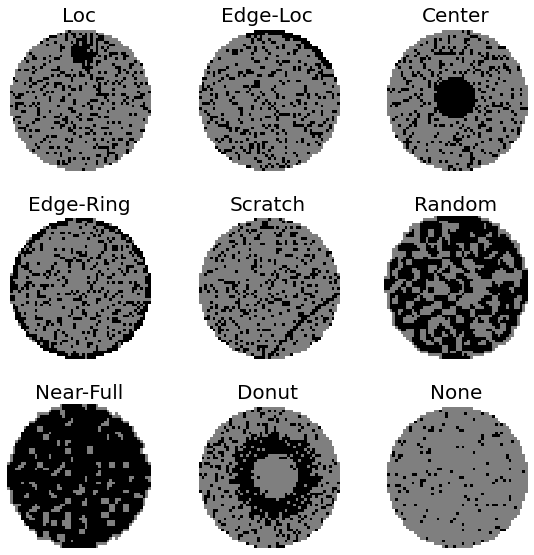

In [49]:
# plot good wafers
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = good_imgs3[x]
    ftype = true_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='gray_r')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}', fontsize=20)

plt.show()

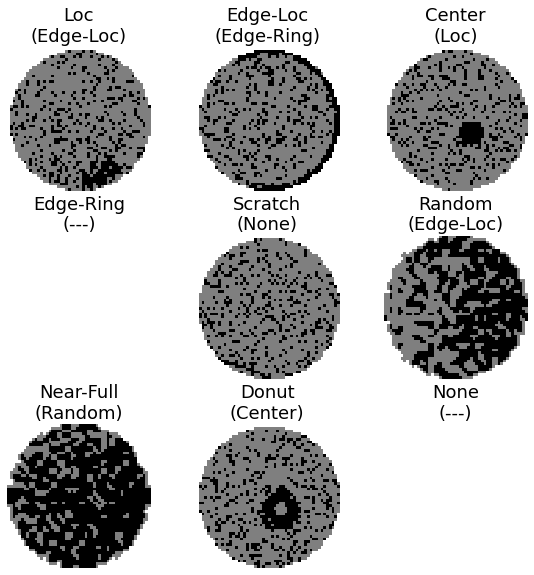

In [45]:
# plot bad wafers
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = bad_imgs3[x]
    ftype = true_labels[x]
    mistake = bad_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='gray_r')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}\n({mistake})', fontsize=18)

plt.show()

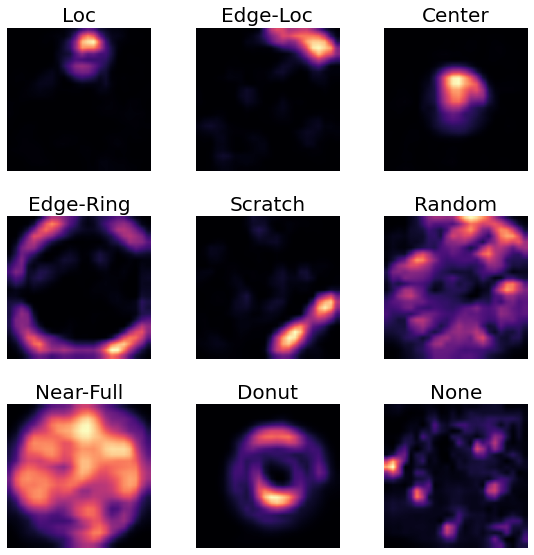

In [62]:
# plot good grad-cams
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = good_gcs[x]
    ftype = true_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='magma')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}', fontsize=20)

plt.show()

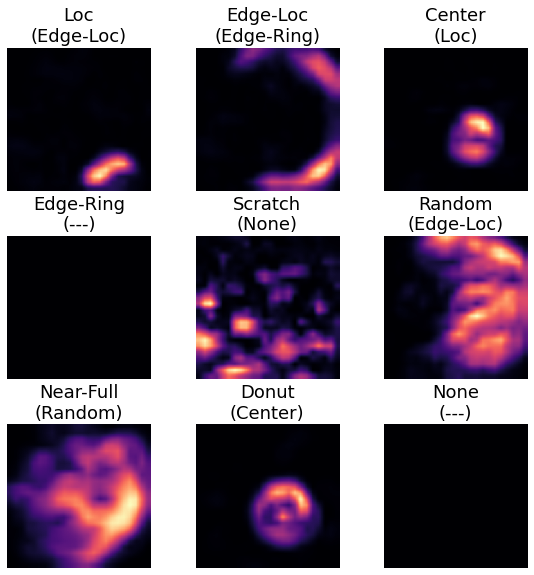

In [63]:
# plot bad grad-cams
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = bad_gcs[x]
    ftype = true_labels[x]
    mistake = bad_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='magma')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}\n({mistake})', fontsize=18)

plt.show()

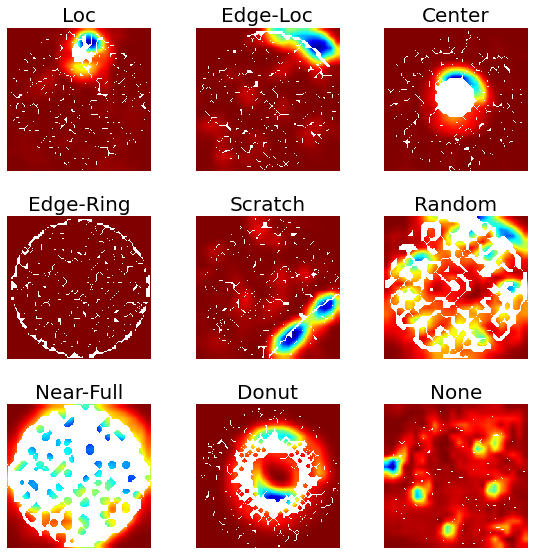

In [58]:
# plot good superimposed thin
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = good_superimposed[x]
    ftype = true_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='gray_r')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}', fontsize=20)

plt.show()

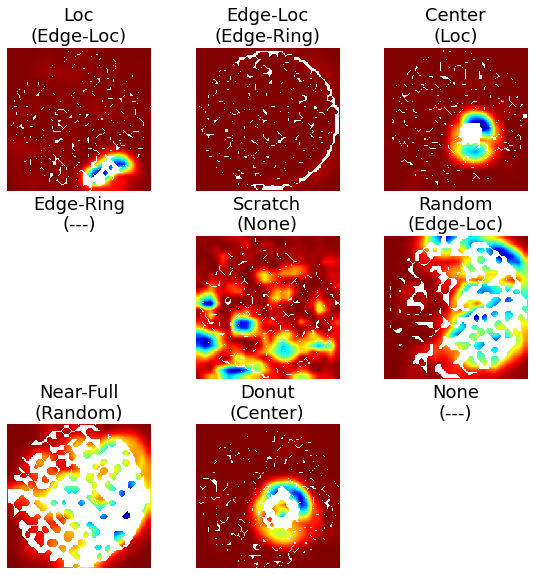

In [57]:
# plot bad superimposed thin
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = bad_superimposed[x]
    ftype = true_labels[x]
    mistake = bad_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='gray_r')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}\n({mistake})', fontsize=18)

plt.show()

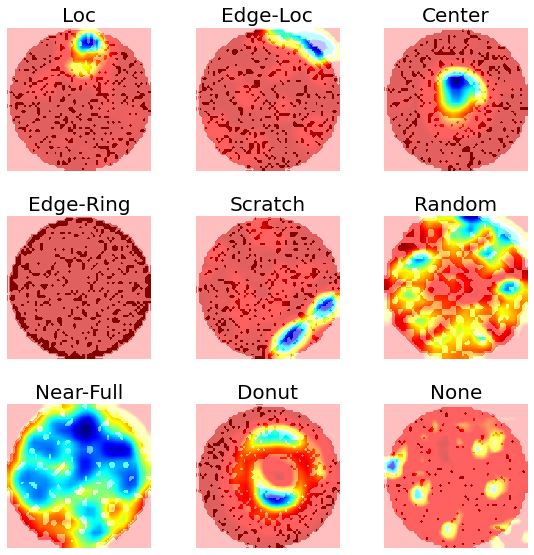

In [56]:
# plot good superimposed
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = good_superimposed2[x]
    ftype = true_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='gray_r')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}', fontsize=20)

plt.show()

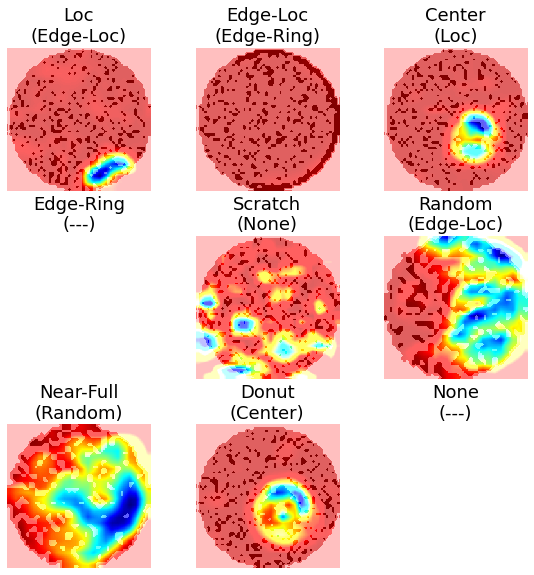

In [55]:
# plot bad superimposed
fig, axs = plt.subplots(3, 3, figsize=[8,8])
fig.tight_layout()

# Nested for loops to loop through all digits and number of examples input for plotting
for x in range(9):
    img = bad_superimposed2[x]
    ftype = true_labels[x]
    mistake = bad_labels[x]

    # imshow to plot image in axs i,j location in plot
    j = x % 3
    i = int(x/3)
    axs[i, j].imshow(img,
                     interpolation='none',
                     cmap='gray_r')
    axs[i, j].axis('off')

    # label the figure with the index# and defect classification [for future reference]
    axs[i, j].set_title(f'{ftype}\n({mistake})', fontsize=18)

plt.show()